In [1]:
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import random
import numpy as np

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel, ldamodel

from topic_modeler import TopicModeler

random.seed(123)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Table of Contents

* [Model Search (LDA)](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Model-Search-(LDA))
    * [Begin with a small corpus, and unigrams](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Begin-with-a-small-corpus,-and-unigrams)
    * [Compare to n-grams (small corpus)](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Compare-to-ngrams-(small-dataset))
    * [Increase size of corpus used for fitting](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Increase-the-size-of-the-corpus-used-for-fitting)
* [Explore selected model](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Explore-selected-model)
    * [Visualization](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Visualization)
* [Alternative Approach: K-means clustering](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Alternative-Approach:-K-means-clustering)

# Model Search (LDA)

## Begin with a small corpus, and unigrams

To start with, we will explore fitting latent dirichlet allocation on a small dataset. Later, we'll fit the models on larger datasets and compare the coherence.

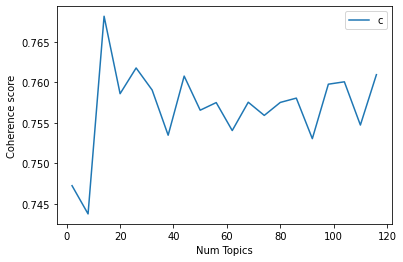

In [2]:
mod = TopicModeler('preprocessed_input/preprocessed_input_small_unigrams.json')
mod.set_texts()
mod.set_dictionary()
mod.set_corpus()

start = 2; stop = 120; step = 6; iterations=300
model_list, coherence_values = mod.optimal_model_search(start, stop, step, iterations)

mod.plot_model_search_results(coherence_values, start, stop, step)

Optimal coherence is found with 2 topics. After 2 topics, the coherence varies a bit but is generally trending downward with the number of topics.

## Compare to ngrams (small dataset)

In [ ]:
model_list, coherence_values = mod.optimal_model_search(start,stop,step,iterations=300)

mod.plot_model_search_results(coherence_values, start, stop, step)

This is an interesting result; overall, none of the models reach of the max coherence value we achived from the unigram model (~0.79); but we see in the n-gram model that models with a relatively large number of topics have pretty good coherence. 

With the n-gram model in particular, the fact that we are using a smaller dataset (only  approx. 100 documents) is probably making things more difficult. We'll next run the model search process on a much larger dataset (approx. 10k documents) and compare.

## Increase the size of the corpus used for fitting

Next, we re-fit the unigram and ngrams models on a larger dataset.

Results of model search on unigrams:


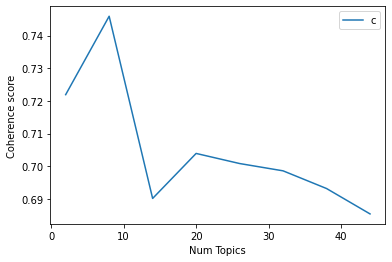

Results of model search on ngrams:


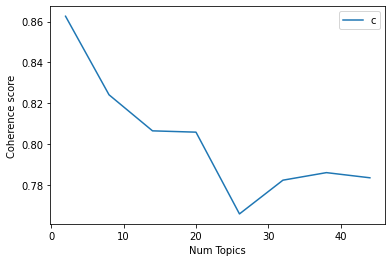

In [3]:
mod1 = TopicModeler('preprocessed_input/preprocessed_input_unigrams.json')
mod1.set_texts()
mod1.set_dictionary()
mod1.set_corpus()

start = 2; stop=50; step=6
np.random.seed(12345)
model_list_unigrams, coherence_values = mod1.optimal_model_search(start,stop,step,iterations=100)

print('Results of model search on unigrams:')
mod1.plot_model_search_results(coherence_values, start, stop, step)

mod2 = TopicModeler('preprocessed_input/preprocessed_input_ngrams.json')
mod2.set_texts()
mod2.set_dictionary()
mod2.set_corpus()

np.random.seed(12345)
model_list_ngrams, coherence_values = mod2.optimal_model_search(start,stop,step,iterations=100)
print('Results of model search on ngrams:')
mod2.plot_model_search_results(coherence_values, start, stop, step)

A few observiations:

    1) Coherence is significantly improved overall.
    2) We now see that models fit to the n-grams dataset have significantly better coherence than models fit to the unigrams dataset.
    3) We still find that models with a relatively small number of topics have better coherence. With n-gram models, the decrease in coherence is more linear while in the unigram models, there is a sharp dropoff. This results in findings such as "a n-gram model with 30 topics has significantly better coherence than a unigram model with 10 topics."
    
It is not exactly clear from the coherence values alone which number of topics will be best for our purposes. While a n-grams model with 2 topics has optimal coherence, seperating the dataset into only two models is not useful. We'll have to explore the models a bit more before making a choice.

# Explore selected model

### Summary of unigrams model

In [4]:
print('Eight topic unigram-based model:')
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"ccpm, offer, replenish, kinematic, israel, achievable, tabulation, credence, identically, ibex",951,0.0954
1,1.0,"marginalization, mmv, assortative, lie, sdma, cbj, homological, munich, ivoting, quantal",1281,0.1285
2,2.0,"hostile, meticulous, remnant, powerpoint, pioneering, customise, managerial, delineated, rademacher, loss",757,0.0759
3,3.0,"rbpf, compressor, b, efs, wordnetdomains, devices, sumo, closely, radon, restoring",1165,0.1169
4,4.0,"capitalize, rho, rugby, slider, orbits, acceptability, reproducible, specifie, ink, kings",1397,0.1401
5,5.0,"val, trials, apps, guidelines, apprentissage, prototypical, community, prerequisite, uninstantiated, disturbance",834,0.0837
6,6.0,"rbf, brazil, nongenetic, prm, exotic, aplicados, nutritional, varying, fungal, blackboxe",1276,0.1280
7,7.0,"metering, mml, huaren, connectedness, palette, binarize, wsd, alphabetically, nonmonotonicity, rationality",2307,0.2314


### Summary of ngrams model:

In [5]:
print('Two topic ngram based model:')
mod2.set_optimal_model(model_list_ngrams, 0)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(2)

Two topics:


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"real life temporal scenarios, cumulative path, precise sense, Machine Learning Perspective, chosen path, distributed asynchronous manner, original MART, astrobiological interest, fuzzy filter, news portals",6268,0.6288
1,1.0,"fuzzy theory, traditional SDAs, unabashed speculation, second popular distance function, general submodular minimization, representational support, simple Perceptron algorithm, maximal tractable subclasses, reward model Markovian reward model, known inference procedures",3700,0.3712


In [6]:
print('Eight topics ngram based model:')
mod2.set_optimal_model(model_list_ngrams, 1)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

Eight topics ngram based model:


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"tractable convex program, optimization engine, life archival purposes, Infinite classes, unlabeled documents, database similarity search, natural language comprehension generation system, descriptive analysis, RDP histograms, networked organization",1730,0.1736
1,1.0,"arbitrary pairwise similarity measures, Lagrangian positions, causally sound plot progression, problem solving facilities, redundant rules, network anomaly detection, Diesel Engine, possibly infinite family, thematic propositions, soft computing method",1452,0.1457
2,2.0,"slightly restricted form, automat, GPS Pseudorange Based Cooperative Vehicular Distance Measurement, D chart, heuristic nature, useful prototyping tool, Follow Perturbed Leader algorithms, variational lower bound yields, feedback delay, given graded modal logic formula",1295,0.1299
3,3.0,"algorithm properties, single edge graphs, WTA fixed point, neuro linguistic processing, local nature, high probability, StructBoost, rule based inference systems, present experimental work, method outperform",840,0.0843
4,4.0,"new visualization software Pajek, environment dynamics, additionally objects, tailored Particle Markov Chain Monte Carlo samplers, high interest, Bayesian similarity measure, initial condition, online convex optimization algorithms, clinicopathological conference, connected matroids",1200,0.1204
5,5.0,"Argumentative inference, presumably complete mathematical theory, consistent way, exponential rate, Littlewood Offord lemma, Outcome Type variable, Immune System, conventional recommender systems, SVRG method, sampling process",1167,0.1171
6,6.0,"Modelling Concurrent Behaviors, comprehensive framework, correct derivatives, Special focus, algorithm implementations, tags p, certain prototypical patterns, comprehensive algorithmic derivation, transport contract, expert utility function",1263,0.1267
7,7.0,"intruders, Manhattan Non negative Matrix Factorization, low resolution CCTV probe images, worker nodes, weighted expert voting, practical interest calls, ALDP, baseline approach, sparse model, consistent conceptual design solutions",1021,0.1024


## Visualization

In [7]:
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod1.model, mod1.corpus, mod1.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.000859 -0.000359       1        1  22.012186
4      0.000209 -0.000408       2        1  14.591475
6     -0.000566  0.000789       3        1  13.185573
1      0.000108  0.000300       4        1  12.960255
3     -0.000723 -0.000285       5        1  11.574172
0     -0.000139 -0.000483       6        1   9.558496
5      0.000557  0.000778       7        1   8.270095
2     -0.000306 -0.000332       8        1   7.847749, topic_info=               Term       Freq      Total Category  logprob  loglift
12856  phonetically  40.000000  40.000000  Default  30.0000  30.0000
949        addition  39.000000  39.000000  Default  29.0000  29.0000
3626    reliability  39.000000  39.000000  Default  28.0000  28.0000
21317      launched  39.000000  39.000000  Default  27.0000  27.0000
19095       hostile  42.000000  42.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
7137       schipper   4.179168  43.583680   Topic8  -9.7374   0.2004
661    significance   4.184313  44.493849   Topic8  -9.7361   0.1809
7458         analog   4.172991  44.142495   Topic8  -9.7388   0.1862
16294    undeserved   4.151245  42.609922   Topic8  -9.7441   0.2163
3791        underly   4.145198  42.366230   Topic8  -9.7455   0.2205

[403 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
12069      1  0.200040  acceptability
12069      2  0.177814  acceptability
12069      3  0.111134  acceptability
12069      4  0.111134  acceptability
12069      5  0.133360  acceptability
...      ...       ...            ...
5872       4  0.125529          xmlkr
5872       5  0.150634          xmlkr
5872       6  0.100423          xmlkr
5872       7  0.075317          xmlkr
5872       8  0.075317          xmlkr

[3096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 7, 2, 4, 1, 6, 3])

In [8]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod2.model, mod2.corpus, mod2.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000180 -0.000132       1        1  16.936814
1     -0.000150  0.000943       2        1  14.235729
2     -0.001217 -0.000253       3        1  13.206360
6      0.000522 -0.000329       4        1  13.101011
4      0.000024  0.000216       5        1  12.340200
5      0.000252  0.000382       6        1  11.758976
7      0.000300  0.000006       7        1  10.128785
3      0.000089 -0.000833       8        1   8.292124, topic_info=                                 Term      Freq     Total Category  logprob  \
35759                Association Rule  2.000000  2.000000  Default  30.0000   
106712  Expert Classification Systems  2.000000  2.000000  Default  29.0000   
18182                 different parts  2.000000  2.000000  Default  28.0000   
79874                         Scrapie  2.000000  2.000000  Default  27.0000   
60171            simple tagging model  2.000000  2.000000  Default  26.0000   
...                               ...       ...       ...      ...      ...   
102487                  Sensitivities  0.305650  2.823882   Topic8 -11.5492   
137352                       ARPlaces  0.306827  2.943373   Topic8 -11.5453   
13888                 historical maps  0.305462  2.858568   Topic8 -11.5498   
131689           initial seed patches  0.305849  2.902872   Topic8 -11.5485   
8447                 high performance  0.305825  3.000161   Topic8 -11.5486   

        loglift  
35759   30.0000  
106712  29.0000  
18182   28.0000  
79874   27.0000  
60171   26.0000  
...         ...  
102487   0.2664  
137352   0.2288  
13888    0.2536  
131689   0.2395  
8447     0.2065  

[433 rows x 6 columns], token_table=        Topic      Freq                              Term
term                                                     
137352      1  0.339746                          ARPlaces
137323      1  0.341838  American style crossword puzzles
105160      1  0.311086           Argumentative inference
105160      6  0.311086           Argumentative inference
40192       1  0.340862                       BN dynamics
...       ...       ...                               ...
121008      1  0.329520                    value learning
18518       2  0.350428             varying Poisson model
130101      1  0.329344            weighted expert voting
93342       1  0.358572                      worker nodes
72145       1  0.344984                  zero constraints

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 7, 5, 6, 8, 4])

# Conclusion of LDA exploration

The ngram model, despite having a greater coherence metric, is seperating topics based on very specific technical terms found in the arXiv dataset. We see in visualization that virually all of the terms appper only once or twice in the corpus. In the bubble plot, we see that there is not great seperation between topics; it appears that maybe 3 topics would be the best model (2, 3, and 8). It looks like we can also reduce the number of topics in the unigram model (which we already knew from the coherence plot, but is confirmed in the bubble plot).

In all cases, the topics are not very human interpretable. This may not be too surprising; as put in a Stack Overflow post:

<blockquote>"LDA's "topics" are a mathematical construct and you shouldn't confuse them with actual human topics. You can end up with topics that have no human interpretation -- they're more like artifacts of the process than actual topics -- and you can end up with topics at different levels of abstraction, including topics that basically cover the same human topic. It's a bit like reading tea leaves."
LDA vs word2vec, URL (version: 2019-02-20): https://stats.stackexchange.com/q/393447</blockquote>

Below, we run a final search over a finer-gained range that covers models with a small number of topics (2 through 7).

Results of model search on unigrams:


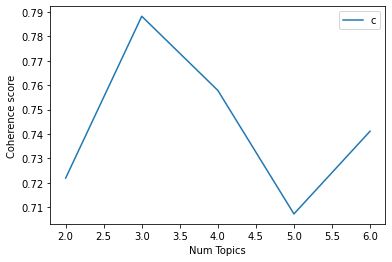

Results of model search on ngrams:


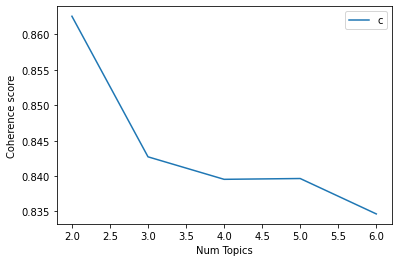

In [10]:
mod1 = TopicModeler('preprocessed_input/preprocessed_input_unigrams.json')
mod1.set_texts()
mod1.set_dictionary()
mod1.set_corpus()

start = 2; stop=7; step=1
np.random.seed(12345)
model_list_unigrams, coherence_values = mod1.optimal_model_search(start,stop,step,iterations=300)

print('Results of model search on unigrams:')
mod1.plot_model_search_results(coherence_values, start, stop, step)

mod2 = TopicModeler('preprocessed_input/preprocessed_input_ngrams.json')
mod2.set_texts()
mod2.set_dictionary()
mod2.set_corpus()

np.random.seed(12345)
model_list_ngrams, coherence_values = mod2.optimal_model_search(start,stop,step,iterations=00)
print('Results of model search on ngrams:')
mod2.plot_model_search_results(coherence_values, start, stop, step)

In [12]:
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod1.model, mod1.corpus, mod1.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000761 -0.000291       1        1  40.864927
0      0.000638 -0.000501       2        1  31.239208
2      0.000124  0.000792       3        1  27.895865, topic_info=               Term       Freq      Total Category  logprob  loglift
2439            lay  40.000000  40.000000  Default  30.0000  30.0000
20956    meticulous  41.000000  41.000000  Default  29.0000  29.0000
6803            aco  40.000000  40.000000  Default  28.0000  28.0000
15745        elvira  44.000000  44.000000  Default  27.0000  27.0000
5789      decodable  40.000000  40.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
7458         analog  14.308946  45.675234   Topic3  -9.7748   0.1160
661    significance  14.342902  46.471059   Topic3  -9.7725   0.1011
11152          bath  14.306687  46.020855   Topic3  -9.7750   0.1083
6015          quiet  14.292751  45.676836   Topic3  -9.7760   0.1149
3791        underly  14.225586  45.739916   Topic3  -9.7807   0.1088

[197 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
126        1  0.344255  achievable
126        2  0.390155  achievable
126        3  0.275404  achievable
6803       1  0.321383         aco
6803       2  0.346105         aco
...      ...       ...         ...
2809       2  0.273973     wordnet
2809       3  0.251142     wordnet
15921      1  0.479651     wrongly
15921      2  0.296927     wrongly
15921      3  0.228405     wrongly

[561 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [16]:
mod2.set_optimal_model(model_list_ngrams, 4)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod2.model, mod2.corpus, mod2.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000528 -0.000373       1        1  18.688292
2     -0.000387  0.001009       2        1  18.620112
5      0.001046  0.000173       3        1  17.740128
3     -0.000370 -0.000128       4        1  15.813135
4      0.000053 -0.000691       5        1  15.098000
0      0.000187  0.000010       6        1  14.040334, topic_info=                            Term      Freq     Total Category  logprob  \
4066           binary preference  2.000000  2.000000  Default  30.0000   
3037                 expressions  2.000000  2.000000  Default  29.0000   
28837    Randomized Input Models  2.000000  2.000000  Default  28.0000   
22006              large dataset  2.000000  2.000000  Default  27.0000   
71429   optimized implementation  2.000000  2.000000  Default  26.0000   
...                          ...       ...       ...      ...      ...   
19064              single neuron  0.511730  2.902373   Topic6 -11.5604   
46251       performance gradient  0.512503  2.926622   Topic6 -11.5589   
77124   Orientation Faithfulness  0.510099  2.869002   Topic6 -11.5636   
80623                Theoretical  0.511945  2.958660   Topic6 -11.5600   
119919               Ullman Disc  0.509940  2.932082   Topic6 -11.5639   

        loglift  
4066    30.0000  
3037    29.0000  
28837   28.0000  
22006   27.0000  
71429   26.0000  
...         ...  
19064    0.2277  
46251    0.2209  
77124    0.2361  
80623    0.2090  
119919   0.2141  

[333 rows x 6 columns], token_table=        Topic      Freq  \
term                      
27922       4  0.385953   
135193      4  0.374785   
100492      2  0.343931   
71216       3  0.346329   
139257      1  0.342040   
...       ...       ...   
56383       1  0.341450   
56383       3  0.341450   
12681       1  0.345427   
12681       2  0.345427   
12681       4  0.345427   

                                                               Term  
term                                                                 
27922   Acute Bacterial Meningitis Clinical Decision Support System  
135193                         Adaptive Stochastic Resource Control  
100492                                              Bayesian Belief  
71216                                        Bayesian network model  
139257                                                 Bounded Risk  
...                                                             ...  
56383                             virtually instantaneous knowledge  
56383                             virtually instantaneous knowledge  
12681                                       word proximity networks  
12681                                       word proximity networks  
12681                                       word proximity networks  

[584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 4, 5, 1])

The seperation is much better in these models.

# Prepare final dataset

In [ ]:
document_number = 0

with open("input/input_small.json", "r") as jsonFile:
     data = json.load(jsonFile)

for d in data:
    d["topic_id"] = 1  # TODO get from model output

with open("output/arxiv_with_topics.json", "w") as jsonFile:
    json.dump(data, jsonFile)